In [35]:
import multiprocessing as mp
from datetime import datetime
import sys
sys.path.insert(0, '../../data/siim-pneumothorax')

import fastai
from fastai.vision import *
from mask_functions import *

fastai.__version__

'1.0.54'

In [24]:
SZ = 256
path = Path(f'../../data/siim-pneumothorax/')

#eliminate all predictions with a few (noise_th) pixesls
noise_th = 75.0*(SZ/128.0)**2 #threshold for the number of predicted pixels

In [3]:
# Setting div=True in open_mask
class SegmentationLabelList(SegmentationLabelList):
    def open(self, fn): return open_mask(fn, div=True)
    
class SegmentationItemList(SegmentationItemList):
    _label_cls = SegmentationLabelList

# Setting transformations on masks to False on test set
def transform(self, tfms:Optional[Tuple[TfmList,TfmList]]=(None,None), **kwargs):
    if not tfms: tfms=(None,None)
    assert is_listy(tfms) and len(tfms) == 2
    self.train.transform(tfms[0], **kwargs)
    self.valid.transform(tfms[1], **kwargs)
    kwargs['tfm_y'] = False # Test data has no labels
    if self.test: self.test.transform(tfms[1], **kwargs)
    return self
fastai.data_block.ItemLists.transform = transform

In [4]:
# Create databunch
data = (SegmentationItemList.from_folder(path=path/'train_png')
        .split_by_rand_pct(0.2)
        .label_from_func(lambda x : str(x).replace('train', 'mask'), classes=[0, 1])
        .add_test((path/'test_png').ls(), label=None)
        .transform(get_transforms(), size=SZ, tfm_y=True)
        .databunch(path=Path('.'), bs=16)
        .normalize(imagenet_stats))

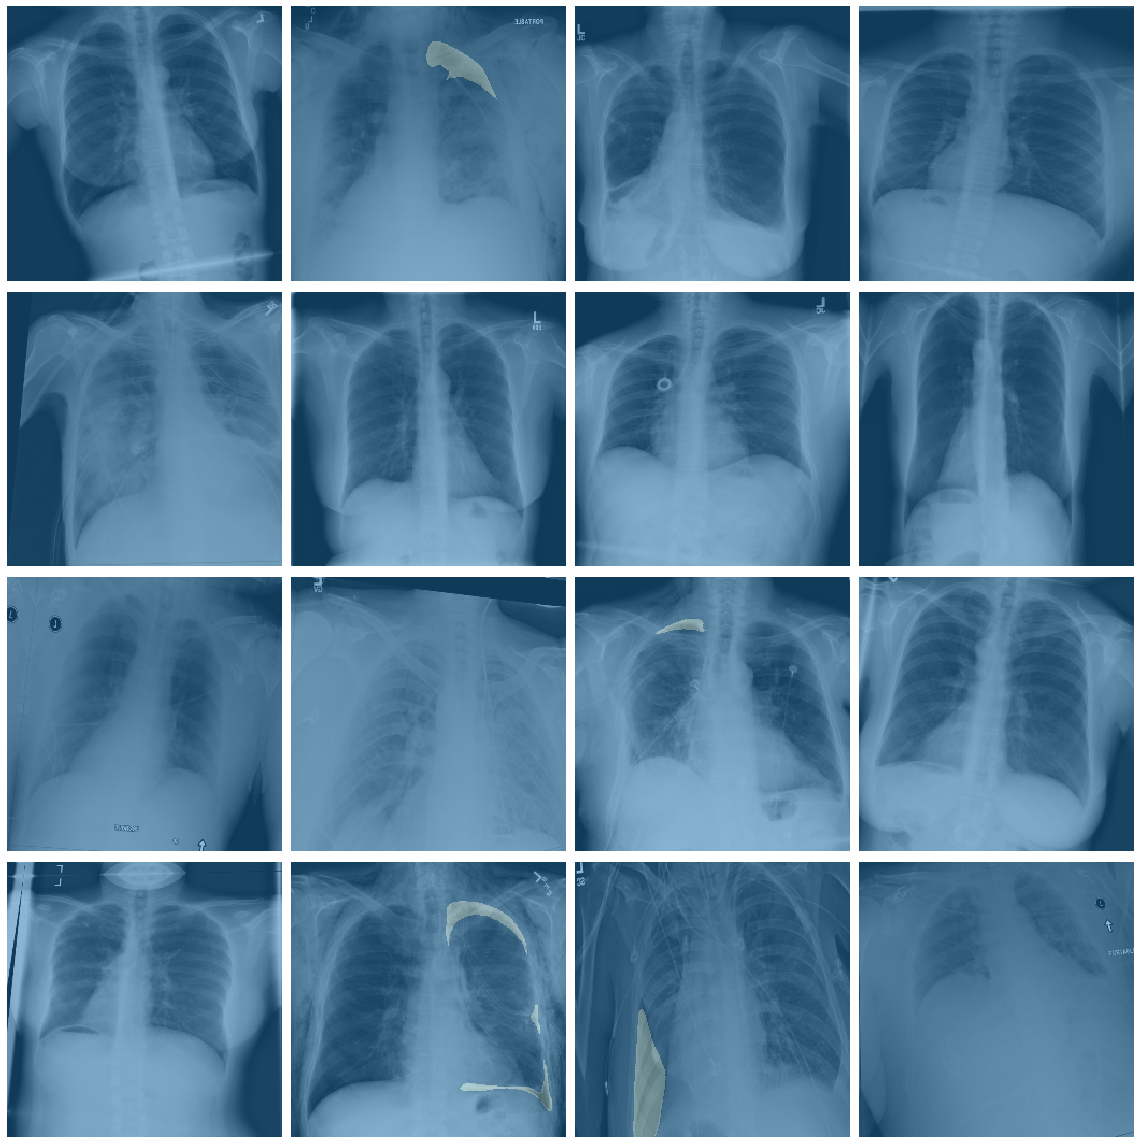

In [5]:
# Display some images with masks
data.show_batch()

In [6]:
# Create U-Net with a pretrained resnet34 as encoder
learn = unet_learner(data, models.resnet34, metrics=[dice])

In [7]:
# Fit one cycle of 6 epochs with max lr of 1e-3
learn.fit_one_cycle(6)

epoch,train_loss,valid_loss,dice,time
0,0.018897,0.017426,0.014939,03:59
1,0.028603,0.027107,0.014939,03:49
2,0.014528,0.013956,0.014939,03:49
3,0.013150,0.012137,0.021267,03:49
4,0.011141,0.010718,0.130788,03:49
5,0.010571,0.010500,0.189608,03:49


In [8]:
# Unfreeze the encoder (resnet34)
learn.unfreeze()

In [9]:
# Fit one cycle of 12 epochs
lr = 1e-3
learn.fit_one_cycle(12, slice(lr/30, lr))

epoch,train_loss,valid_loss,dice,time
0,0.010879,0.010485,0.243494,03:56
1,0.010041,0.010609,0.181819,03:56
2,0.012561,0.011522,0.096426,03:55
3,0.011901,0.011303,0.078110,03:55
4,0.014285,0.012183,0.020780,03:55
5,0.013472,0.010616,0.231704,03:56
6,0.010675,0.009717,0.247328,03:56
7,0.011916,0.010388,0.205140,03:55
8,0.010571,0.009633,0.280818,03:54
9,0.008906,0.009530,0.243566,03:56


In [36]:
now = datetime.now()
learn.save('unet_{}_{}'.format(now.strftime('%Y%m%d-%H%M%S'), SZ))


## Eval

In [10]:
# Predictions for the validation set
preds, ys = learn.get_preds()
preds = preds[:,1,...]
ys = ys.squeeze()

In [11]:
def dice_overall(preds, targs):
    n = preds.shape[0]
    preds = preds.view(n, -1)
    targs = targs.view(n, -1)
    intersect = (preds * targs).sum(-1).float()
    union = (preds+targs).sum(-1).float()
    u0 = union==0
    intersect[u0] = 1
    union[u0] = 2
    return (2. * intersect / union)

In [12]:
# Find optimal threshold
dices = []
thrs = np.arange(0.01, 1, 0.01)
for i in progress_bar(thrs):
    preds_m = (preds>i).long()
    dices.append(dice_overall(preds_m, ys).mean())
dices = np.array(dices)

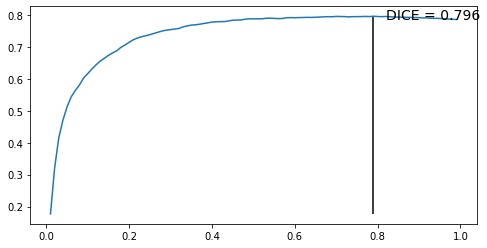

best_dice: 0.7961161136627197 @ thr: 0.79


In [19]:
best_dice = dices.max()
best_thr = thrs[dices.argmax()]

plt.figure(figsize=(8,4))
plt.plot(thrs, dices)
plt.vlines(x=best_thr, ymin=dices.min(), ymax=dices.max())
plt.text(best_thr+0.03, best_dice-0.01, f'DICE = {best_dice:.3f}', fontsize=14);
plt.show()

print('best_dice: {} @ thr: {}'.format(best_dice, best_thr))

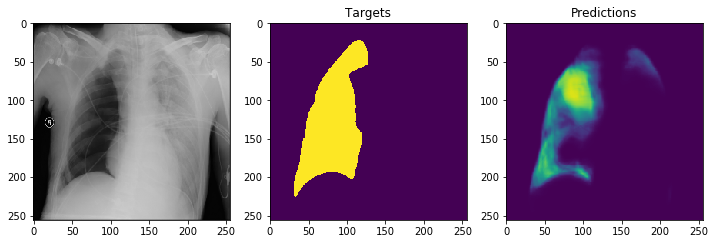

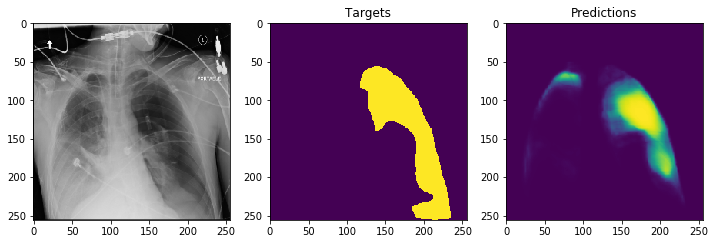

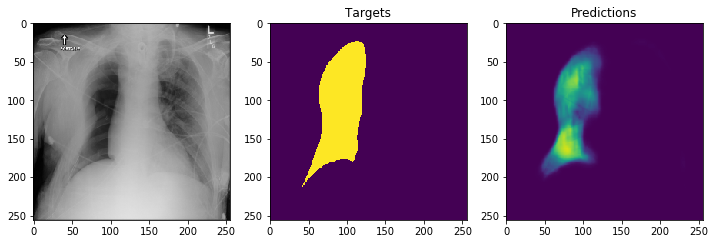

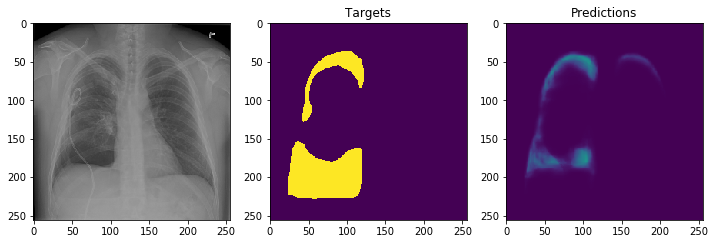

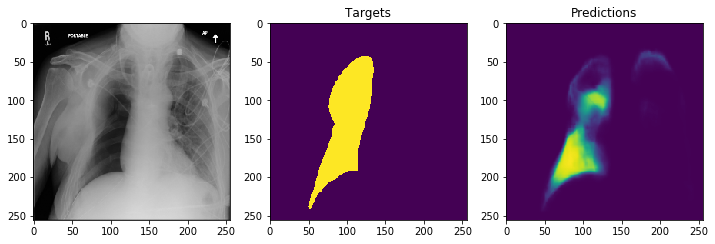

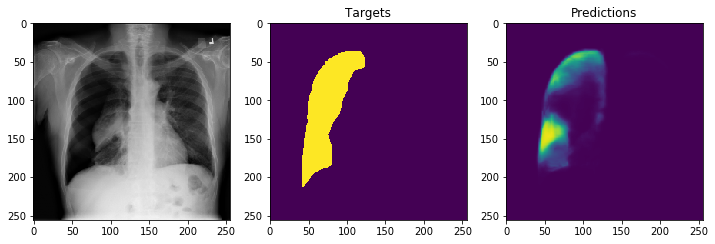

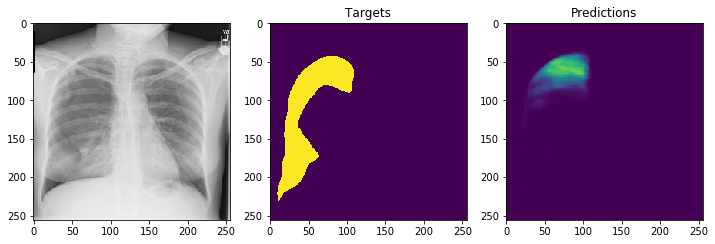

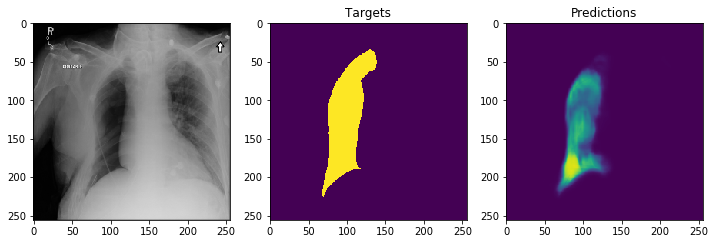

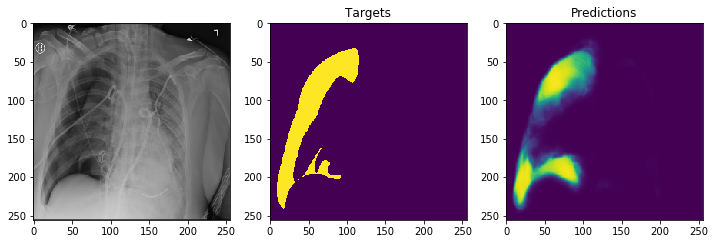

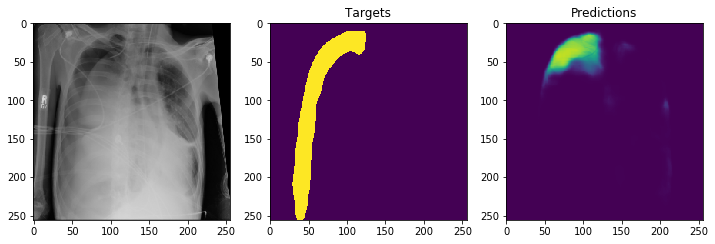

In [14]:
# Plot some samples
rows = 10
plot_idx = ys.sum((1,2)).sort(descending=True).indices[:rows]
for idx in plot_idx:
    fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(12, 4))
    ax0.imshow(data.valid_ds[idx][0].data.numpy().transpose(1,2,0))
    ax1.imshow(ys[idx], vmin=0, vmax=1)
    ax2.imshow(preds[idx], vmin=0, vmax=1)
    ax1.set_title('Targets')
    ax2.set_title('Predictions')

## Test

In [21]:
# Predictions for test set
preds, _ = learn.get_preds(ds_type=DatasetType.Test)


In [25]:
# noise removal
pt_clean = preds.clone()
pt_clean[pt_clean.view(pt_clean.shape[0],-1).sum(-1) < noise_th,...] = 0.0


In [26]:
pt_mask = (pt_clean[:,1,...]>best_thr).long().numpy()
print(pt_mask.sum())


23872


In [32]:
# Generate rle encodings in parallel (images are first converted to the original size)
mask_size = 1024

def mask_worker(mask):
    im = PIL.Image.fromarray((mask.T*255).astype(np.uint8)).resize((mask_size, mask_size))
    im = np.asarray(im)
    rle = mask2rle(im, mask_size, mask_size)
    
    return rle

pool = mp.Pool()
rles = pool.map(mask_worker, pt_mask)


In [33]:
ids = [o.stem for o in data.test_ds.items]
sub_df = pd.DataFrame({'ImageId': ids, 'EncodedPixels': rles})
sub_df.loc[sub_df.EncodedPixels=='', 'EncodedPixels'] = '-1'
sub_df.head()

,ImageId,EncodedPixels
0,1.2.276.0.7230010.3.1.4.8323329.6106.151787519...,-1
1,1.2.276.0.7230010.3.1.4.8323329.6588.151787519...,-1
2,1.2.276.0.7230010.3.1.4.8323329.6014.151787519...,-1
3,1.2.276.0.7230010.3.1.4.8323329.6813.151787520...,-1
4,1.2.276.0.7230010.3.1.4.8323329.699.1517875164...,-1


In [34]:
sub_df.to_csv('unet_sub.csv', index=False)